# Topic modelling using LDA

## Opening the dataset

In [1]:
# IMPORTS
from bertopic import BERTopic
import pandas as pd
import os

c:\Users\20192830\AppData\Local\anaconda3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\20192830\AppData\Local\anaconda3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\20192830\AppData\Local\anaconda3\Lib\site-packages\umap\distances.py:

In [2]:
# Read the data and perform preprocessing on summaries!

df = pd.read_csv("created_data/corrected_full_dataset.csv", parse_dates=["date"]) # Read data into 'df' dataframe
print(df.shape) # Print dataframe shape

docs_summary = df["summary"].tolist() # Create a list containing all article summaries

df.head() # Show first 5 dataframe entries  


(18506, 9)


,index,name,summary,date,lat,lng,paragraphs,publisher,tags
0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-07,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '..."
1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-03,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co..."
2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-30,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern..."
3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-04,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']"
4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-02,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex..."


In [3]:
# # Read the data and perform preprocessing on full paragraphs!

# df = pd.read_csv("data/corrected_full_dataset.csv", parse_dates=["date"]) # Read data into 'df' dataframe
# print(df.shape) # Print dataframe shape

# docs_paragraphs = df["summary"].tolist() # Create a list containing all article summaries

# df.head() # Show first 5 dataframe entries  

In [3]:
test_dataframe = df.copy()
test_dataframe['date'] = pd.to_datetime(test_dataframe['date'], format='%Y-%m-%d')
test_dataframe['date']

pre2015_data = df.loc[(test_dataframe['date'] >= '2011-07-07')
                     & (test_dataframe['date'] < '2014-12-31')]
# Display
pre2015_data


,index,name,summary,date,lat,lng,paragraphs,publisher,tags
0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-07,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '..."
7,The article discusses the suspension of commer...,Entebbe,The article discusses the suspension of commer...,2011-07-07,0.051184,32.463708,COMMERCIAL flights to South Sudan have been su...,New Vision (Kampala),"['Uganda', 'East Africa', 'Business', 'Transpo..."
8,The article discusses the Elders' letter of co...,Juba,The article discusses the Elders' letter of co...,2011-07-07,4.859363,31.571250,The Elders have sent a letter of congratulatio...,The Elders Foundation (London),"['Africa', 'East Africa', 'External Relations'..."
13,The article discusses the preparations for Sou...,Juba,The article discusses the preparations for Sou...,2011-07-07,4.859363,31.571250,Juba — As South Sudan prepares to attain natio...,Sudan Tribune,"['South Sudan', 'East Africa', 'Governance']"
16,The article discusses the warning issued by se...,Juba,The article discusses the warning issued by se...,2011-07-07,4.859363,31.571250,Washington — Two days before celebrating the i...,Inter Press Service,"['South Sudan', 'East Africa', 'Governance', '..."
...,...,...,...,...,...,...,...,...,...
13027,The article discusses South Sudan's informatio...,Bor,The article discusses South Sudan's informatio...,2014-12-25,28.105818,79.922069,"Bor — South Sudan's information minister, Mich...",Sudan Tribune,"['South Sudan', 'East Africa', 'Conflict']"
13028,The article discusses the challenges to peace ...,Jonglei,The article discusses the challenges to peace ...,2014-12-22,6.837966,31.282770,South Sudan's Jonglei state is emblematic of t...,International Crisis Group,"['Governance', 'East Africa', 'South Sudan']"
13029,The article discusses the lack of progress in ...,Juba,The article discusses the lack of progress in ...,2014-12-24,4.859363,31.571250,Juba — The parallel reconciliatory and unity t...,Sudan Tribune,"['Tanzania', 'East Africa', 'Conflict', 'South..."
13030,The article discusses a report published by th...,South Sudan,The article discusses a report published by th...,2014-12-30,6.876992,31.306979,The conflict in South Sudan has seriously hamp...,UN News Service,"['International Organisations', 'East Africa',..."


In [4]:
test_dataframe = df.copy()
test_dataframe['date'] = pd.to_datetime(test_dataframe['date'], format='%Y-%m-%d')
test_dataframe['date']

post2015_data = df.loc[(test_dataframe['date'] >= '2014-12-31')
                     & (test_dataframe['date'] < '2023-04-24')]
# Display
post2015_data

,index,name,summary,date,lat,lng,paragraphs,publisher,tags
12976,The article discusses the dismissal of all cab...,Rumbek,The article discusses the dismissal of all cab...,2014-12-31,6.807249,29.678888,Rumbek — The governor of South Sudan's Lakes s...,Sudan Tribune,"['Governance', 'East Africa', 'South Sudan']"
12978,The article discusses South Sudan's President ...,Juba,The article discusses South Sudan's President ...,2015-01-01,4.859363,31.571250,Juba — South Sudan's president Salva Kiir has ...,Sudan Tribune,"['South Sudan', 'East Africa', 'Governance', '..."
12981,The article discusses the UK's plan to provide...,South Sudan,The article discusses the UK's plan to provide...,2014-12-31,6.876992,31.306979,"London — The UK will provide emergency food, s...",PR Newswire (New York),"['South Sudan', 'East Africa', 'External Relat..."
12985,The article discusses Asuman Kiyingi's involve...,South Sudan,The article discusses Asuman Kiyingi's involve...,2014-12-31,6.876992,31.306979,"Asuman Kiyingi, the minister of state for Regi...",The Observer (Kampala),"['Uganda', 'East Africa', 'Conflict', 'South S..."
12990,The article discusses Sudan and South Sudan ag...,Khartoum airport,The article discusses Sudan and South Sudan ag...,2015-01-01,15.592767,32.552236,Khartoum — Sudan and South Sudan have agreed o...,Sudan Tribune,"['Sudan', 'East Africa', 'Governance', 'Confli..."
...,...,...,...,...,...,...,...,...,...
18497,The article discusses the U.S. Department of S...,Ukraine,The article discusses the U.S. Department of S...,2023-03-20,48.379433,31.165580,"Russia's armed forces have committed ""numerous...","Voice of America (Washington, DC)","['Human Rights', 'East Africa', 'Africa', 'Sou..."
18498,The article discusses the return of members of...,Gambella region,The article discusses the return of members of...,2023-04-20,7.921969,34.153195,Addis Abeba — Members of the Gambella Liberati...,Addis Standard (Addis Ababa),"['Ethiopia', 'East Africa', 'Conflict', 'Sudan..."
18499,The article discusses the completion of pre-de...,Mali,The article discusses the completion of pre-de...,2023-04-18,17.570692,-3.996166,Monrovia — The Armed Forces of Liberia (AFL) h...,FrontPageAfrica (Monrovia),"['South Sudan', 'East Africa', 'West Africa', ..."
18503,The article discusses how Prime Minister Abiy ...,Addis Ababa,The article discusses how Prime Minister Abiy ...,2023-04-23,8.980603,38.757761,Addis Ababa — Prime Minister Abiy Ahmed has ca...,Ethiopian News Agency (Addis Ababa),"['Ethiopia', 'East Africa', 'Governance', 'Con..."


## LatentDirichletAllocation (LDA)

### Preproccessing

In [5]:
#Imports
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

#Plotting
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.lda_model.prepare
%matplotlib inline

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter 



In [6]:
# Only run this cell to run the LDA model on pre 2015 data!

pre2015_data

# Convert to list
data = df.summary.values.tolist()

# Removing the word discusses in the summaries
data = [re.sub('discusses', '', sent) for sent in data]

# Removing the word article in the summaries
data = [re.sub('article', '', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:5])


['The   the passing of the new Constitution of the Republic of South Sudan by '
 'its parliament before the July 7, 2011 deadline. The new Constitution '
 'includes the creation of a new country called the Republic of South Sudan, '
 'with its own coat of arms, national flag, motto, central bank, currency, and '
 'national anthem. It also highlights the right to citizenship in South Sudan '
 'and allows for dual citizenship. The new constitution also allows foreigners '
 'who have married South Sudanese citizens to apply and become citizens. The  '
 'also mentions the settlement of the border issues between the northern and '
 'southern Sudan by calling for a referendum in the contentious oil-rich Abyei '
 'region.',
 'The   the military actions taken by Khartoum in the weeks leading up to '
 'independence for the Republic of South Sudan. The  suggests that the '
 'military actions are a result of the worst elements being fully in charge, '
 'and the intense economic distress in North 

In [ ]:
# Only run this cell to run the LDA model on post 2015 data!

post2015_data

# Convert to list
data = df.summary.values.tolist()

# Removing the word discusses in the summaries
data = [re.sub('discusses', '', sent) for sent in data]

# Removing the word article in the summaries
data = [re.sub('article', '', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:5])


In [7]:
df

# Convert to list
data = df.summary.values.tolist()

# Removing the word discusses in the summaries
data = [re.sub('discusses', '', sent) for sent in data]

# Removing the word article in the summaries
data = [re.sub('article', '', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:5])


['The   the passing of the new Constitution of the Republic of South Sudan by '
 'its parliament before the July 7, 2011 deadline. The new Constitution '
 'includes the creation of a new country called the Republic of South Sudan, '
 'with its own coat of arms, national flag, motto, central bank, currency, and '
 'national anthem. It also highlights the right to citizenship in South Sudan '
 'and allows for dual citizenship. The new constitution also allows foreigners '
 'who have married South Sudanese citizens to apply and become citizens. The  '
 'also mentions the settlement of the border issues between the northern and '
 'southern Sudan by calling for a referendum in the contentious oil-rich Abyei '
 'region.',
 'The   the military actions taken by Khartoum in the weeks leading up to '
 'independence for the Republic of South Sudan. The  suggests that the '
 'military actions are a result of the worst elements being fully in charge, '
 'and the intense economic distress in North 

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])
print(type(data_words))

[['the', 'the', 'passing', 'of', 'the', 'new', 'constitution', 'of', 'the', 'republic', 'of', 'south', 'sudan', 'by', 'its', 'parliament', 'before', 'the', 'july', 'deadline', 'the', 'new', 'constitution', 'includes', 'the', 'creation', 'of', 'new', 'country', 'called', 'the', 'republic', 'of', 'south', 'sudan', 'with', 'its', 'own', 'coat', 'of', 'arms', 'national', 'flag', 'motto', 'central', 'bank', 'currency', 'and', 'national', 'anthem', 'it', 'also', 'highlights', 'the', 'right', 'to', 'citizenship', 'in', 'south', 'sudan', 'and', 'allows', 'for', 'dual', 'citizenship', 'the', 'new', 'constitution', 'also', 'allows', 'foreigners', 'who', 'have', 'married', 'south', 'sudanese', 'citizens', 'to', 'apply', 'and', 'become', 'citizens', 'the', 'also', 'mentions', 'the', 'settlement', 'of', 'the', 'border', 'issues', 'between', 'the', 'northern', 'and', 'southern', 'sudan', 'by', 'calling', 'for', 'referendum', 'in', 'the', 'contentious', 'oil', 'rich', 'abyei', 'region'], ['the', 'the

In [66]:
stopwords = ['article', 'discuss']
for word in list(data_words):  # iterating on a copy since removing will mess things up
    if word in stopwords:
        data_words.remove(word)
print(data_words[:2])

[['the', 'the', 'dismissal', 'of', 'all', 'cabinet', 'members', 'by', 'the', 'governor', 'of', 'lakes', 'state', 'in', 'south', 'sudan', 'who', 'also', 'appointed', 'new', 'county', 'commissioner', 'the', 'reason', 'for', 'the', 'changes', 'were', 'not', 'explained', 'the', 'state', 'has', 'been', 'affected', 'by', 'inter', 'clan', 'clashes', 'and', 'violence', 'since', 'south', 'sudan', 'gained', 'independence', 'in'], ['the', 'south', 'sudans', 'president', 'salva', 'kiir', 'urging', 'citizens', 'to', 'prioritize', 'national', 'interests', 'over', 'individual', 'desires', 'and', 'encouraging', 'them', 'to', 'work', 'towards', 'national', 'unity', 'peace', 'reconciliation', 'forgiveness', 'stability', 'and', 'progress', 'the', 'also', 'mentions', 'the', 'ongoing', 'violence', 'in', 'the', 'country', 'since', 'december', 'with', 'tens', 'of', 'thousands', 'killed', 'and', 'about', 'two', 'million', 'people', 'displaced', 'additionally', 'it', 'notes', 'that', 'the', 'presidents', 'offi

In [67]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])




['dismissal cabinet member governor lake state also appoint new county commissioner reason change explain state affect clan clash violence gain independence', 'south urge citizen prioritize national interest individual desire encourage work national unity peace reconciliation forgiveness stability progress also mention ongoing violence country ten thousand kill about people displace additionally note president office donate money teaching hospital orphanage center church']


In [68]:
print(type(data_lemmatized))
print(data_lemmatized[:2])

<class 'list'>
['dismissal cabinet member governor lake state also appoint new county commissioner reason change explain state affect clan clash violence gain independence', 'south urge citizen prioritize national interest individual desire encourage work national unity peace reconciliation forgiveness stability progress also mention ongoing violence country ten thousand kill about people displace additionally note president office donate money teaching hospital orphanage center church']


In [69]:
# Vectorizing
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(['discuss','article'])

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)


In [70]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.3682566084533232 %


### Building the model for LDA

In [71]:
# Build LDA Model
# print(data_vectorized)
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [72]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1420534.0484735805
Perplexity:  905.9035813335153
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [76]:
# THIS CELL TAKES A LONG TIME TO RUN!! It takes approximately 80 min to run. 
from tqdm import tqdm

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [84]:
# Best Model
best_lda_model = model.best_estimator_

print(best_lda_model)
print(lda)

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

LatentDirichletAllocation()
LatentDirichletAllocation()
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -309036.38973893184
Model Perplexity:  833.2122558798409


### Plotting the model

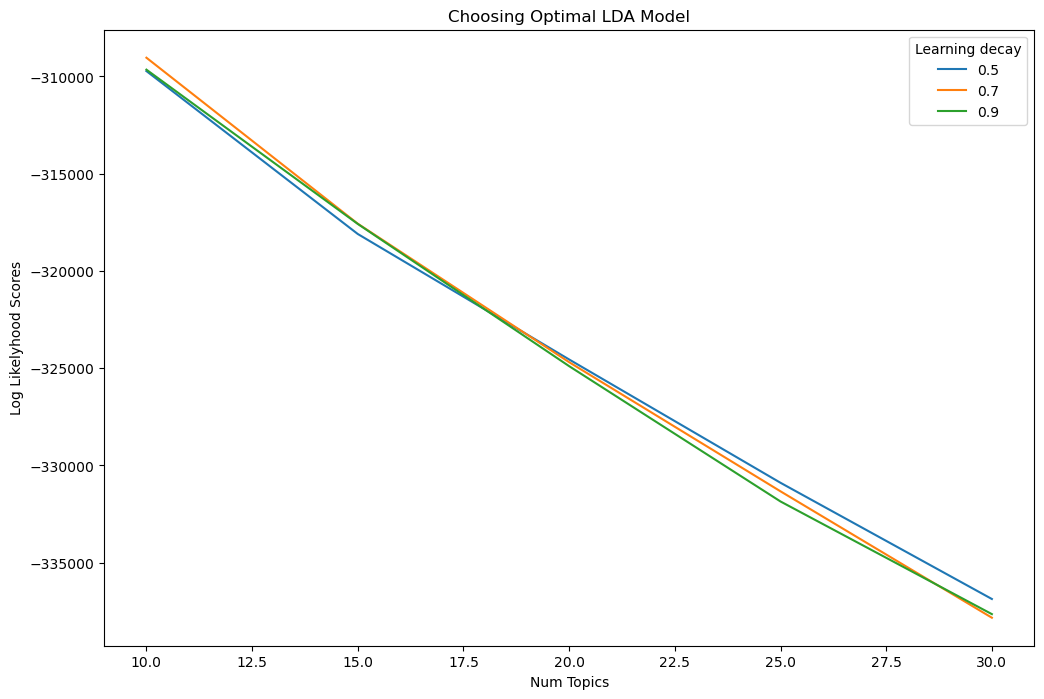

In [78]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [86]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

print(lda_output)
print(lda_output.shape)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style .style.map(color_green).map(make_bold)
df_document_topic.to_csv('created_data/df_document_topics_post2015.csv')
df_document_topic.head(15)

[[0.8822196  0.00500083 0.07777241 ... 0.00500093 0.00500071 0.00500173]
 [0.11234732 0.00285772 0.0028579  ... 0.105467   0.00285804 0.48244619]
 [0.00312565 0.00312532 0.63275038 ... 0.00312544 0.00312541 0.00312554]
 ...
 [0.06436111 0.00294135 0.00294167 ... 0.00294215 0.0029416  0.41787913]
 [0.00400033 0.00400035 0.17017487 ... 0.31781781 0.19510491 0.29289983]
 [0.00270324 0.0027032  0.00270291 ... 0.00270321 0.00270346 0.00270344]]
(5481, 10)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
Doc0,0.88,0.01,0.08,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Doc1,0.11,0.00,0.00,0.08,0.00,0.20,0.00,0.11,0.00,0.48
Doc2,0.00,0.00,0.63,0.00,0.00,0.00,0.34,0.00,0.00,0.00
Doc3,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.45,0.32,0.00
Doc4,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.14,0.78,0.00
Doc5,0.17,0.63,0.00,0.00,0.07,0.00,0.00,0.12,0.00,0.00
Doc6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00
Doc7,0.26,0.00,0.00,0.00,0.00,0.00,0.14,0.58,0.00,0.00
Doc8,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Doc9,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.77,0.00,0.00


In [87]:
reading_data_document_topic = pd.read_csv('created_data/df_document_topics_post2015.csv')
extracted_col = df['date']
reading_data_document_topic.insert(0, 'date', extracted_col)
reading_data_document_topic.to_csv('created_data/final_output_lda_post2015.csv', index=False, )


In [88]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.to_csv('created_data/df_topic_keywords_post2015.csv')
df_topic_keywords

,abandon,abduct,abducted,abduction,ability,able,abroad,absence,abuse,abyei,...,worth,wound,write,year,yei,young,youth,yumbe,zimbabwe,zone
Topic0,4.794879,3.604954,3.599244,3.216303,0.100025,7.944641,0.100014,5.527522,0.107657,0.100008,...,0.100006,3.213728,5.951583,81.158959,12.467777,11.205402,18.585592,0.100020,0.100013,3.374827
Topic1,0.100060,5.257217,1.257156,2.755166,0.100011,5.892375,7.238395,0.100021,0.100013,0.100000,...,4.157490,0.100003,0.100232,67.984050,0.100020,0.100015,0.100025,0.100006,0.100018,0.100006
Topic2,9.842839,0.100007,0.100007,0.100012,14.620599,9.401783,2.711983,0.100012,0.100008,0.100008,...,0.100065,1.289230,0.100003,184.004863,6.697823,16.130540,0.100015,0.100004,3.859911,0.100036
Topic3,4.869997,0.100011,0.100010,0.100008,7.299376,3.947673,12.349537,0.100015,0.100008,3.328702,...,12.807546,0.100000,0.141984,41.005302,0.100003,2.385275,0.100014,0.100009,0.100004,0.100015
Topic4,0.100007,5.572110,0.100040,24.703973,1.586648,0.100017,0.100000,0.100016,196.989683,0.100000,...,0.101701,0.100002,4.655201,19.149257,8.134095,18.937325,5.200422,0.100004,0.100009,12.148435
Topic5,0.100006,37.732573,8.443454,40.724513,12.173774,0.100048,0.100002,4.563538,0.103029,44.188190,...,5.317353,34.308462,0.100005,41.850247,0.100021,30.333522,9.959434,4.181109,0.100009,7.994594
Topic6,0.100027,2.333115,0.100006,0.100010,0.100037,13.653506,0.100033,0.100717,0.100009,10.878432,...,0.100100,0.588558,0.100004,93.201040,0.100005,6.097288,14.057863,24.018845,0.100005,4.393055
Topic7,3.892134,0.100002,0.100020,0.100005,8.405989,4.540823,0.100006,11.151129,0.100012,14.195888,...,0.100011,0.100012,1.693550,150.390572,0.100236,1.181704,0.100008,0.100002,0.100004,3.908428
Topic8,0.100019,0.100006,0.100061,0.100003,0.100010,0.100032,0.100018,0.100010,0.100001,37.908771,...,0.100009,0.100000,7.465720,13.911170,0.100003,0.100234,17.780550,0.100002,6.518943,21.239571
Topic9,0.100031,0.100004,0.100001,0.100006,12.513531,2.319101,0.100013,14.157020,0.199580,0.100002,...,1.115718,0.100005,9.691717,92.344541,0.100017,69.528695,39.016075,0.100000,15.921084,9.641035


In [89]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      15.449029  29.706728       1        1  20.898844
2     -19.049547  31.724869       2        1  12.974115
0      -5.159077 -15.247232       3        1  12.556496
8      -4.266363  10.362782       4        1  10.490476
9     -26.321379 -30.564659       5        1   9.145440
5     -31.459562   0.854898       6        1   7.733638
6       7.528523 -38.941669       7        1   7.496982
4      39.859524  10.532619       8        1   6.897341
1      17.444372  -3.290013       9        1   6.597891
3      33.972202 -24.070629      10        1   5.208779, topic_info=            Term         Freq        Total Category  logprob  loglift
1768     refugee  1128.000000  1128.000000  Default  30.0000  30.0000
1522       peace  2923.000000  2923.000000  Default  29.0000  29.0000
896         food   939.000000   939.000000  Default  28.0000  28.0000
1885       right   686.000000   686.000000  Default  27.0000  27.0000
76     agreement  1609.000000  1609.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
961   government    69.469296  2639.644417  Topic10  -5.0526  -0.6827
244       border    51.660157   458.894991  Topic10  -5.3488   0.7707
1941    security    54.658341  1194.574865  Topic10  -5.2924  -0.1296
934         fund    47.289051   261.475996  Topic10  -5.4372   1.2448
2066       state    50.418388  1512.186391  Topic10  -5.3731  -0.4461

[711 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
8         8  0.996047   abuse
13        2  0.566645  access
13        3  0.008763  access
13        4  0.035050  access
13        5  0.008763  access
...     ...       ...     ...
2386      5  0.450540   young
2386      6  0.193089   young
2386      7  0.038618   young
2386      8  0.122290   young
2386     10  0.012873   young

[2069 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 1, 9, 10, 6, 7, 5, 2, 4])

In [83]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.to_csv('created_data/output_model_LDA_post2015.csv', index=False, index_label=True)
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,government,force,rebel,south,people,war,violence,state,country,fighting,sudanese,conflict,civilian,attack,group
Topic 1,government,oil,south,journalist,kenyan,sudanese,release,arrest,country,security,medium,authority,service,trader,national
Topic 2,food,people,humanitarian,aid,conflict,need,crisis,country,assistance,provide,affect,face,insecurity,situation,famine
Topic 3,south,sanction,sudan,arm,sudanese,include,member,report,east,country,bank,african,embargo,impose,eac
Topic 4,right,human,report,child,violence,violation,abuse,woman,crime,sexual,include,group,team,international,conflict
Topic 5,health,child,attack,case,people,covid,medical,worker,death,woman,include,disease,violence,state,outbreak
Topic 6,refugee,mission,camp,child,sudanese,police,unmiss,civilian,protection,south,peacekeeping,force,peacekeeper,school,provide
Topic 7,peace,agreement,government,party,leader,transitional,process,deal,south,security,igad,sign,conflict,political,national
Topic 8,country,meeting,minister,discuss,visit,development,project,cooperation,border,sudanese,relation,security,state,oil,south
Topic 9,country,peace,south,conflict,african,war,highlight,international,sudanese,court,political,civil,community,need,government
